El objetivo de este documento es probar una red bayesiana para realizar predicción sobre los datos de sensores. Para ello aprendemos una red bayesiana y ajustamos sus parámetros, considerando los datos de entrada como continuos (no realizamos discretización), por eso veremos que se samplean la distribución de cada nodo/variable a una gaussiana.

El dataset utilizado es de 20 sensores cercanos entre sí, distribuidos en una parcela de 100x100, más los sensores de una estación meteorológica (variables cuyo nombre empieza con Est\_ ). Estos datos se han agrupado de forma diaria (dataset sensores.csv) creando variables como la media, máxima, mínima, temperatura a las 15,12 y 18 hs de cada sensor.




In [40]:
library(bnlearn)                       
library(forecast)

### Preprocesando el dataset 

In [2]:
library(readr)
sensores <- read_csv("../data/sensores.csv")
colnames(sensores)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_datetime(format = "")
)
See spec(...) for full column specifications.


[1] "X1"              "S10.max"         "S11.max"         "S12.max"        
  [5] "S13.max"         "S14.max"         "S15.max"         "S16.max"        
  [9] "S17.max"         "S18.max"         "S19.max"         "S1.max"         
 [13] "S20.max"         "S2.max"          "S3.max"          "S4.max"         
 [17] "S5.max"          "S6.max"          "S7.max"          "S8.max"         
 [21] "S9.max"          "S10.media"       "S11.media"       "S12.media"      
 [25] "S13.media"       "S14.media"       "S15.media"       "S16.media"      
 [29] "S17.media"       "S18.media"       "S19.media"       "S1.media"       
 [33] "S20.media"       "S2.media"        "S3.media"        "S4.media"       
 [37] "S5.media"        "S6.media"        "S7.media"        "S8.media"       
 [41] "S9.media"        "S10.min"         "S11.min"         "S12.min"        
 [45] "S13.min"         "S14.min"         "S15.min"         "S16.min"        
 [49] "S17.min"         "S18.min"         "S19.min"         "S1.min"         
 [53] "S20.min"         "S2.min"          "S3.min"          "S4.min"         
 [57] "S5.min"          "S6.min"          "S7.min"          "S8.min"         
 [61] "S9.min"          "S10.15hs"        "S11.15hs"        "S12.15hs"       
 [65] "S13.15hs"        "S14.15hs"        "S15.15hs"        "S16.15hs"       
 [69] "S17.15hs"        "S18.15hs"        "S19.15hs"        "S1.15hs"        
 [73] "S20.15hs"        "S2.15hs"         "S3.15hs"         "S4.15hs"        
 [77] "S5.15hs"         "S6.15hs"         "S7.15hs"         "S8.15hs"        
 [81] "S9.15hs"         "S10.12hs"        "S11.12hs"        "S12.12hs"       
 [85] "S13.12hs"        "S14.12hs"        "S15.12hs"        "S16.12hs"       
 [89] "S17.12hs"        "S18.12hs"        "S19.12hs"        "S1.12hs"        
 [93] "S20.12hs"        "S2.12hs"         "S3.12hs"         "S4.12hs"        
 [97] "S5.12hs"         "S6.12hs"         "S7.12hs"         "S8.12hs"        
[101] "S9.12hs"         "S10.18hs"        "S11.18hs"        "S12.18hs"       
[105] "S13.18hs"        "S14.18hs"        "S15.18hs"        "S16.18hs"       
[109] "S17.18hs"        "S18.18hs"        "S19.18hs"        "S1.18hs"        
[113] "S20.18hs"        "S2.18hs"         "S3.18hs"         "S4.18hs"        
[117] "S5.18hs"         "S6.18hs"         "S7.18hs"         "S8.18hs"        
[121] "S9.18hs"         "Est.humedad_min" "Est.humedad_med" "Est.humedad_max"
[125] "Est.temp_min"    "Est.temp_max"    "Est.temp_med"

In [3]:
nrow(sensores)

[1] 465

Procedemos a armar un dataset con las variables, colocando los datos de hace dos días, luego hace un día y luego día presente. Por ello, desfazamos el dataset para que queden primero las variables en T-2, T-1 y luego en t o tiempo presente.

Más adelante nos preguntaremos por la predicción de la temperatura mínima en t (por ejemplo para un sensor especifico S11.min_t

In [7]:
# como denomino a las variables que quiero predecir

pred_sensores = c("S10.min_t","S11.min_t","S12.min_t","S13.min_t","S14.min_t","S15.min_t","S16.min_t","S18.min_t", "S19.min_t","S1.min_t","S20.min_t","S2.min_t","S3.min_t","S4.min_t","S5.min_t",
                  "S6.min_t","S7.min_t","S8.min_t","S9.min_t")

In [8]:

#, descarto la primer columna que es el timestamp o fecha
sensores_T_2 <- sensores[1:(nrow(sensores)-2),-1] 
sensores_T_1 <- sensores[2:(nrow(sensores)-1),-1] # no incluyo la primera fila
sensores_t <- sensores[3:nrow(sensores),] 


# renombro las columnas 
colnames(sensores_T_2) <- paste(colnames(sensores_T_2),"_T_2",sep="")
colnames(sensores_T_1) <- paste(colnames(sensores_T_1),"_T_1",sep="")
colnames(sensores_t) <- paste(colnames(sensores_t),"_t",sep="")


#del tiempo presente solo me interesa la temperatura mínima
sensores_t <- sensores_t[,pred_sensores]

# creo dataset de datos de T-2, T-1 y t
df <- cbind.data.frame(sensores_T_2,sensores_T_1,sensores_t)

colnames(df)

[1] "S10.max_T_2"         "S11.max_T_2"         "S12.max_T_2"        
  [4] "S13.max_T_2"         "S14.max_T_2"         "S15.max_T_2"        
  [7] "S16.max_T_2"         "S17.max_T_2"         "S18.max_T_2"        
 [10] "S19.max_T_2"         "S1.max_T_2"          "S20.max_T_2"        
 [13] "S2.max_T_2"          "S3.max_T_2"          "S4.max_T_2"         
 [16] "S5.max_T_2"          "S6.max_T_2"          "S7.max_T_2"         
 [19] "S8.max_T_2"          "S9.max_T_2"          "S10.media_T_2"      
 [22] "S11.media_T_2"       "S12.media_T_2"       "S13.media_T_2"      
 [25] "S14.media_T_2"       "S15.media_T_2"       "S16.media_T_2"      
 [28] "S17.media_T_2"       "S18.media_T_2"       "S19.media_T_2"      
 [31] "S1.media_T_2"        "S20.media_T_2"       "S2.media_T_2"       
 [34] "S3.media_T_2"        "S4.media_T_2"        "S5.media_T_2"       
 [37] "S6.media_T_2"        "S7.media_T_2"        "S8.media_T_2"       
 [40] "S9.media_T_2"        "S10.min_T_2"         "S11.min_T_2"        
 [43] "S12.min_T_2"         "S13.min_T_2"         "S14.min_T_2"        
 [46] "S15.min_T_2"         "S16.min_T_2"         "S17.min_T_2"        
 [49] "S18.min_T_2"         "S19.min_T_2"         "S1.min_T_2"         
 [52] "S20.min_T_2"         "S2.min_T_2"          "S3.min_T_2"         
 [55] "S4.min_T_2"          "S5.min_T_2"          "S6.min_T_2"         
 [58] "S7.min_T_2"          "S8.min_T_2"          "S9.min_T_2"         
 [61] "S10.15hs_T_2"        "S11.15hs_T_2"        "S12.15hs_T_2"       
 [64] "S13.15hs_T_2"        "S14.15hs_T_2"        "S15.15hs_T_2"       
 [67] "S16.15hs_T_2"        "S17.15hs_T_2"        "S18.15hs_T_2"       
 [70] "S19.15hs_T_2"        "S1.15hs_T_2"         "S20.15hs_T_2"       
 [73] "S2.15hs_T_2"         "S3.15hs_T_2"         "S4.15hs_T_2"        
 [76] "S5.15hs_T_2"         "S6.15hs_T_2"         "S7.15hs_T_2"        
 [79] "S8.15hs_T_2"         "S9.15hs_T_2"         "S10.12hs_T_2"       
 [82] "S11.12hs_T_2"        "S12.12hs_T_2"        "S13.12hs_T_2"       
 [85] "S14.12hs_T_2"        "S15.12hs_T_2"        "S16.12hs_T_2"       
 [88] "S17.12hs_T_2"        "S18.12hs_T_2"        "S19.12hs_T_2"       
 [91] "S1.12hs_T_2"         "S20.12hs_T_2"        "S2.12hs_T_2"        
 [94] "S3.12hs_T_2"         "S4.12hs_T_2"         "S5.12hs_T_2"        
 [97] "S6.12hs_T_2"         "S7.12hs_T_2"         "S8.12hs_T_2"        
[100] "S9.12hs_T_2"         "S10.18hs_T_2"        "S11.18hs_T_2"       
[103] "S12.18hs_T_2"        "S13.18hs_T_2"        "S14.18hs_T_2"       
[106] "S15.18hs_T_2"        "S16.18hs_T_2"        "S17.18hs_T_2"       
[109] "S18.18hs_T_2"        "S19.18hs_T_2"        "S1.18hs_T_2"        
[112] "S20.18hs_T_2"        "S2.18hs_T_2"         "S3.18hs_T_2"        
[115] "S4.18hs_T_2"         "S5.18hs_T_2"         "S6.18hs_T_2"        
[118] "S7.18hs_T_2"         "S8.18hs_T_2"         "S9.18hs_T_2"        
[121] "Est.humedad_min_T_2" "Est.humedad_med_T_2" "Est.humedad_max_T_2"
[124] "Est.temp_min_T_2"    "Est.temp_max_T_2"    "Est.temp_med_T_2"   
[127] "S10.max_T_1"         "S11.max_T_1"         "S12.max_T_1"        
[130] "S13.max_T_1"         "S14.max_T_1"         "S15.max_T_1"        
[133] "S16.max_T_1"         "S17.max_T_1"         "S18.max_T_1"        
[136] "S19.max_T_1"         "S1.max_T_1"          "S20.max_T_1"        
[139] "S2.max_T_1"          "S3.max_T_1"          "S4.max_T_1"         
[142] "S5.max_T_1"          "S6.max_T_1"          "S7.max_T_1"         
[145] "S8.max_T_1"          "S9.max_T_1"          "S10.media_T_1"      
[148] "S11.media_T_1"       "S12.media_T_1"       "S13.media_T_1"      
[151] "S14.media_T_1"       "S15.media_T_1"       "S16.media_T_1"      
[154] "S17.media_T_1"       "S18.media_T_1"       "S19.media_T_1"      
[157] "S1.media_T_1"        "S20.media_T_1"       "S2.media_T_1"       
[160] "S3.media_T_1"        "S4.media_T_1"        "S5.media_T_1"       
[163] "S6.media_T_1"        "S7.media_T_1"        "S8.media_T_1"       
[166] "S9.media_T_1"        "S10.min_T_1" 

In [9]:
# muestro cantidad de filas y columnas 
ncol(df)
nrow(df)

[1] 271

[1] 463

Separación de los datos en conjunto de entrenamiento y testeo

In [41]:
463*.70

[1] 324.1

In [42]:
training.set = df[1:324, ] # This is training set to learn the parameters
test.set = df[325:nrow(df), ]  # This is test set to give as evidence

Plot de mínimas diarias del conjunto de testeo

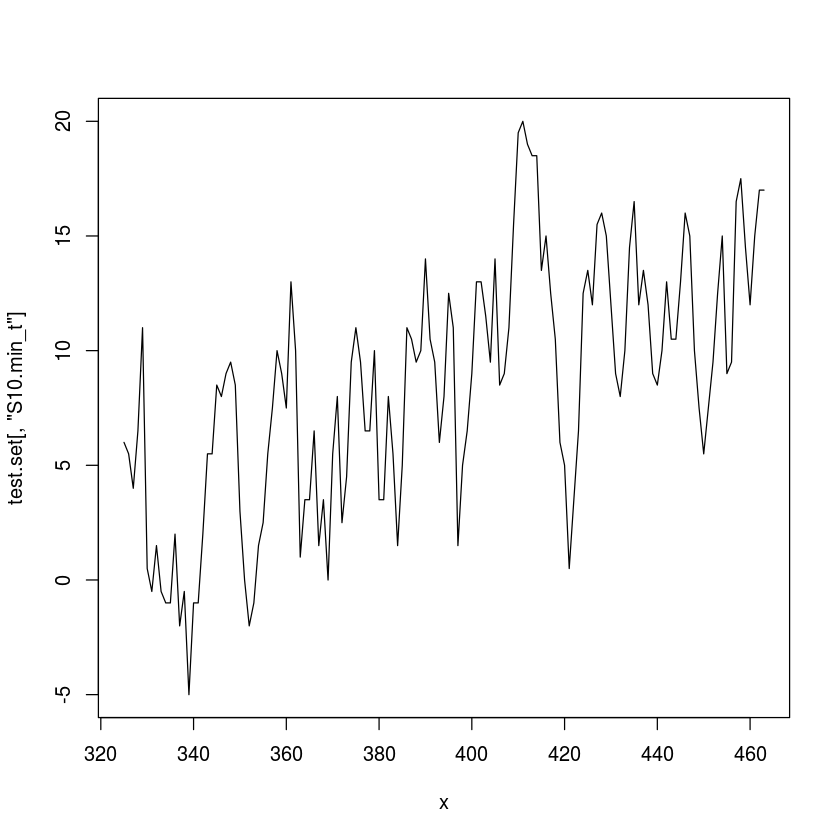

In [13]:
x = seq(from=325,to=(325+nrow(test.set)-1),by=1)
plot(x, test.set[,"S10.min_t"],type="l")

### Entrenando una Bayesian network con hill-climbing

Armando la blacklist: arcos que no serán incluidos en la red bayesiana. No nos interesa relacionar las variables _t entre sí, 
pues a priori sabemos que no contamos con dicha información

In [14]:
bl <- data.frame(from=character(),to=character(),stringsAsFactors=FALSE)
levels(bl$from) <- pred_sensores
levels(bl$to) <- pred_sensores
str(bl)
total <- length(pred_sensores)


'data.frame':	0 obs. of  2 variables:
 $ from: atomic  
  ..- attr(*, "levels")= chr  "S10.min_t" "S11.min_t" "S12.min_t" "S13.min_t" ...
 $ to  : atomic  
  ..- attr(*, "levels")= chr  "S10.min_t" "S11.min_t" "S12.min_t" "S13.min_t" ...


In [15]:

for(i in 1:total)
{
    bl1 = data.frame(from = rep(pred_sensores[i],total), to = pred_sensores)
    bl2 = data.frame(from = pred_sensores, to = rep(pred_sensores[i],total))
    bl = rbind.data.frame(bl,bl1,bl2)
}

print(bl)

         from        to
1   S10.min_t S10.min_t
2   S10.min_t S11.min_t
3   S10.min_t S12.min_t
4   S10.min_t S13.min_t
5   S10.min_t S14.min_t
6   S10.min_t S15.min_t
7   S10.min_t S16.min_t
8   S10.min_t S18.min_t
9   S10.min_t S19.min_t
10  S10.min_t  S1.min_t
11  S10.min_t S20.min_t
12  S10.min_t  S2.min_t
13  S10.min_t  S3.min_t
14  S10.min_t  S4.min_t
15  S10.min_t  S5.min_t
16  S10.min_t  S6.min_t
17  S10.min_t  S7.min_t
18  S10.min_t  S8.min_t
19  S10.min_t  S9.min_t
20  S10.min_t S10.min_t
21  S11.min_t S10.min_t
22  S12.min_t S10.min_t
23  S13.min_t S10.min_t
24  S14.min_t S10.min_t
25  S15.min_t S10.min_t
26  S16.min_t S10.min_t
27  S18.min_t S10.min_t
28  S19.min_t S10.min_t
29   S1.min_t S10.min_t
30  S20.min_t S10.min_t
31   S2.min_t S10.min_t
32   S3.min_t S10.min_t
33   S4.min_t S10.min_t
34   S5.min_t S10.min_t
35   S6.min_t S10.min_t
36   S7.min_t S10.min_t
37   S8.min_t S10.min_t
38   S9.min_t S10.min_t
39  S11.min_t S10.min_t
40  S11.min_t S11.min_t
41  S11.min_t S1

Armaremos una whitelist, lista de arcos que si o sí tiene que tener la red bayesiana.
Consideraremos arcos dirigidos desde las variables _T_1 y _T_2 hacia t  de un mismo sensor


In [16]:
wl <- data.frame(from=character(),to=character(),stringsAsFactors=FALSE)
#levels(bl$from) <- pred_sensores
#levels(bl$to) <- pred_sensores
str(wl)
total <- length(pred_sensores)

'data.frame':	0 obs. of  2 variables:
 $ from: chr 
 $ to  : chr 


In [17]:
s <- unlist(strsplit(pred_sensores,split=".",fixed = TRUE))
sensors <- s[grep("S",s)]
sensors

v <- colnames(training.set)

#vars_ejemplo <- v[grepl( sensors[1] , v)] # extraigo todas las variables relacionadas con sensor
#vars_ejemplo <- vars_ejemplo[-length(vars)] # quito la última variable min_t
#vars_ejemplo

sensor <- unlist(strsplit(pred_sensores[10],split=".",fixed = TRUE))[1]
sensor
sensor <- paste(sensor,".",sep="")
sensor
vars <- v[grepl( sensor, v, fixed = TRUE)] # extraigo todas las variables relacionadas con sensor
vars
vars <- vars[-length(vars)] # quito la última variable min_t
vars

[1] "S10" "S11" "S12" "S13" "S14" "S15" "S16" "S18" "S19" "S1"  "S20" "S2" 
[13] "S3"  "S4"  "S5"  "S6"  "S7"  "S8"  "S9"

[1] "S1"

[1] "S1."

[1] "S1.max_T_2"   "S1.media_T_2" "S1.min_T_2"   "S1.15hs_T_2"  "S1.12hs_T_2" 
 [6] "S1.18hs_T_2"  "S1.max_T_1"   "S1.media_T_1" "S1.min_T_1"   "S1.15hs_T_1" 
[11] "S1.12hs_T_1"  "S1.18hs_T_1"  "S1.min_t"

[1] "S1.max_T_2"   "S1.media_T_2" "S1.min_T_2"   "S1.15hs_T_2"  "S1.12hs_T_2" 
 [6] "S1.18hs_T_2"  "S1.max_T_1"   "S1.media_T_1" "S1.min_T_1"   "S1.15hs_T_1" 
[11] "S1.12hs_T_1"  "S1.18hs_T_1"

In [18]:

for(i in 1:total)
{
    sensor <- unlist(strsplit(pred_sensores[i],split=".",fixed = TRUE))[1]
    sensor <- paste(sensor,".",sep="")
    vars <- v[grepl( sensor, v, fixed = TRUE)] # extraigo todas las variables relacionadas con sensor
    vars <- vars[-length(vars)] # quito la última variable min_t

    wl1 = data.frame(from = vars, to = pred_sensores[i])
    wl = rbind.data.frame(wl,wl1)
}
print(wl)


             from        to
1     S10.max_T_2 S10.min_t
2   S10.media_T_2 S10.min_t
3     S10.min_T_2 S10.min_t
4    S10.15hs_T_2 S10.min_t
5    S10.12hs_T_2 S10.min_t
6    S10.18hs_T_2 S10.min_t
7     S10.max_T_1 S10.min_t
8   S10.media_T_1 S10.min_t
9     S10.min_T_1 S10.min_t
10   S10.15hs_T_1 S10.min_t
11   S10.12hs_T_1 S10.min_t
12   S10.18hs_T_1 S10.min_t
13    S11.max_T_2 S11.min_t
14  S11.media_T_2 S11.min_t
15    S11.min_T_2 S11.min_t
16   S11.15hs_T_2 S11.min_t
17   S11.12hs_T_2 S11.min_t
18   S11.18hs_T_2 S11.min_t
19    S11.max_T_1 S11.min_t
20  S11.media_T_1 S11.min_t
21    S11.min_T_1 S11.min_t
22   S11.15hs_T_1 S11.min_t
23   S11.12hs_T_1 S11.min_t
24   S11.18hs_T_1 S11.min_t
25    S12.max_T_2 S12.min_t
26  S12.media_T_2 S12.min_t
27    S12.min_T_2 S12.min_t
28   S12.15hs_T_2 S12.min_t
29   S12.12hs_T_2 S12.min_t
30   S12.18hs_T_2 S12.min_t
31    S12.max_T_1 S12.min_t
32  S12.media_T_1 S12.min_t
33    S12.min_T_1 S12.min_t
34   S12.15hs_T_1 S12.min_t
35   S12.12hs_T_1 S1

In [19]:
start_time <- Sys.time()
# learn BN structure on training set data , restart por defecto es 0
# modificar restart a 10 no hizo mucho efecto en los resultados de predicción
res = hc(training.set, whitelist=wl,blacklist = bl)
end_time <- Sys.time()
end_time - start_time

Time difference of 10.34194 mins

Mostramos la estructura de la red bayesiana creada con hc

In [20]:
res


  Bayesian network learned via Score-based methods

  model:
   [S12.max_T_1][S13.max_T_1|S12.max_T_1][S14.max_T_1|S12.max_T_1:S13.max_T_1]
   [S17.max_T_1|S12.max_T_1:S14.max_T_1][S14.15hs_T_1|S14.max_T_1]
   [S18.max_T_1|S13.max_T_1:S14.max_T_1:S17.max_T_1]
   [S2.max_T_1|S13.max_T_1:S17.max_T_1:S18.max_T_1]
   [S11.max_T_1|S13.max_T_1:S14.max_T_1:S2.max_T_1]
   [S15.max_T_1|S11.max_T_1:S12.max_T_1:S14.max_T_1:S17.max_T_1:S18.max_T_1]
   [S9.max_T_1|S11.max_T_1:S12.max_T_1:S15.max_T_1:S2.max_T_1:S14.15hs_T_1]
   [S19.max_T_1|S11.max_T_1:S12.max_T_1:S15.max_T_1:S9.max_T_1]
   [S4.max_T_1|S11.max_T_1:S12.max_T_1:S15.max_T_1:S17.max_T_1:S19.max_T_1:S2.max_T_1:S9.max_T_1]
   [S11.18hs_T_1|S19.max_T_1]
   [S6.max_T_1|S11.max_T_1:S15.max_T_1:S18.max_T_1:S2.max_T_1:S4.max_T_1:S9.max_T_1:S14.15hs_T_1]
   [S17.15hs_T_1|S14.max_T_1:S17.max_T_1:S19.max_T_1:S4.max_T_1:S14.15hs_T_1]
   [S10.max_T_1|S12.max_T_1:S17.max_T_1:S2.max_T_1:S6.max_T_1]
   [S7.max_T_1|S12.max_T_1:S13.max_T_1:S14.max_T_1:

Aprendizaje de parámetros 

In [22]:
start_time <- Sys.time()
fitted = bn.fit(res, training.set)     # learning of parameters
end_time <- Sys.time()
end_time - start_time

Time difference of 0.2730947 secs

Imprimimos los parámetros para los nodos que nos interesan predecir

In [23]:
fitted[pred_sensores]

$S10.min_t

  Parameters of node S10.min_t (Gaussian distribution)

Conditional density: S10.min_t | S10.max_T_2 + S10.media_T_2 + S2.media_T_2 + S10.min_T_2 + S10.15hs_T_2 + S10.12hs_T_2 + S10.18hs_T_2 + Est.humedad_med_T_2 + Est.temp_min_T_2 + S10.max_T_1 + S10.media_T_1 + S3.media_T_1 + S10.min_T_1 + S10.15hs_T_1 + S10.12hs_T_1 + S10.18hs_T_1 + S20.18hs_T_1
Coefficients:
        (Intercept)          S10.max_T_2        S10.media_T_2  
        -9.30256424          -0.01342298          -2.18785524  
       S2.media_T_2          S10.min_T_2         S10.15hs_T_2  
         2.04693362           0.07033331           0.02792178  
       S10.12hs_T_2         S10.18hs_T_2  Est.humedad_med_T_2  
         0.04512678          -0.12284425           0.04598495  
   Est.temp_min_T_2          S10.max_T_1        S10.media_T_1  
         0.24185197           0.25488694          -2.04556827  
       S3.media_T_1          S10.min_T_1         S10.15hs_T_1  
         2.69639834           0.25275199       

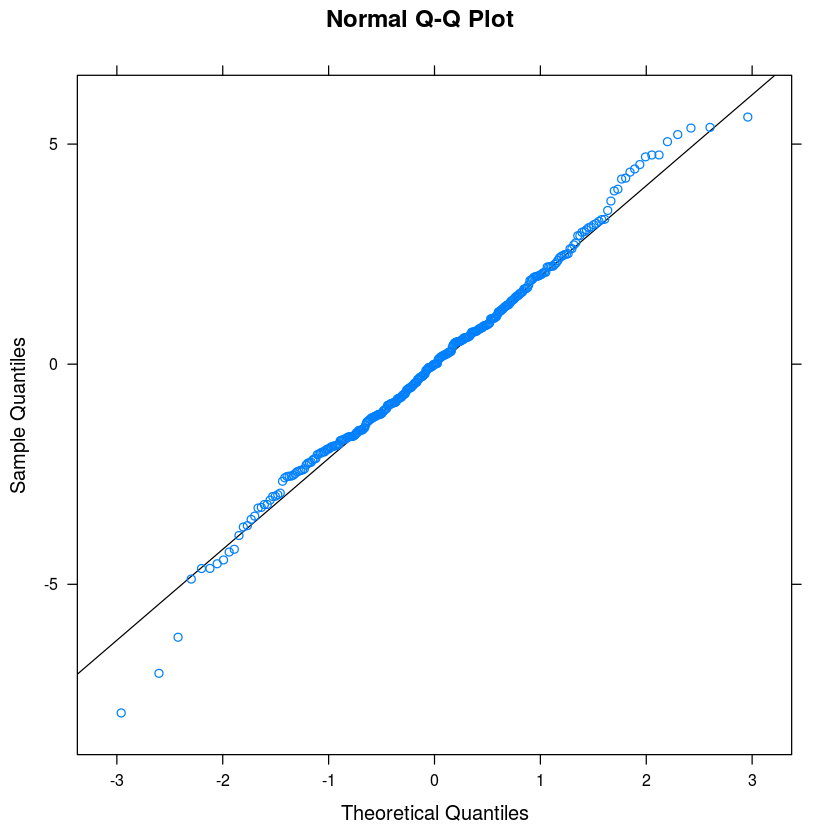

In [24]:
bn.fit.qqplot(fitted$S14.min_t)

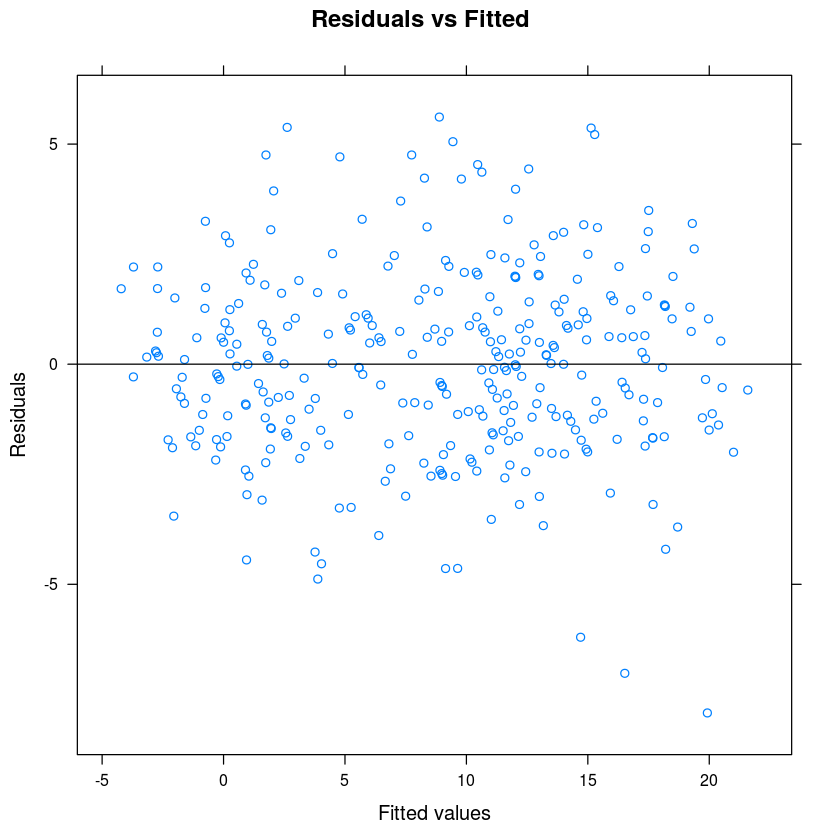

In [25]:
bn.fit.xyplot(fitted$S14.min_t) #pred_sensores

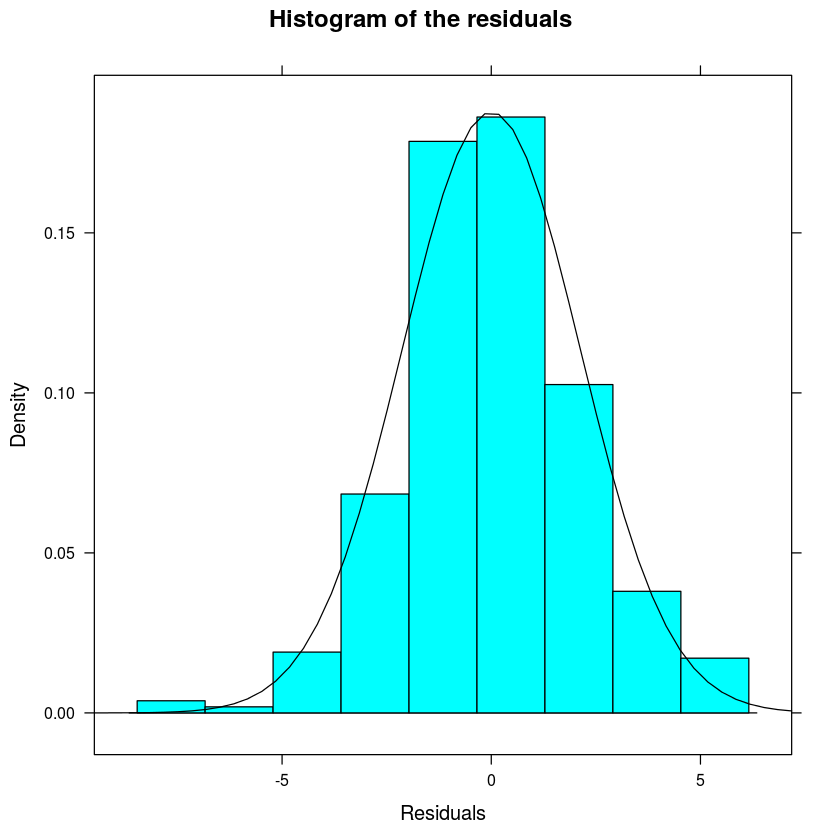

In [26]:
bn.fit.histogram(fitted$S14.min_t)

### Visualizando la matriz de adyacencia

In [27]:
#matriz de adyacencia
print(amat(res))

                    S10.max_T_2 S11.max_T_2 S12.max_T_2 S13.max_T_2 S14.max_T_2
S10.max_T_2                   0           0           1           0           0
S11.max_T_2                   0           0           0           1           0
S12.max_T_2                   0           0           0           1           0
S13.max_T_2                   0           0           0           0           1
S14.max_T_2                   0           0           0           0           0
S15.max_T_2                   0           1           1           0           1
S16.max_T_2                   0           0           0           0           0
S17.max_T_2                   0           0           0           0           0
S18.max_T_2                   0           0           0           0           1
S19.max_T_2                   0           1           1           0           0
S1.max_T_2                    0           0           0           0           0
S20.max_T_2                   0         

### Markov blanket 

In [28]:
for(i in 1:length(pred_sensores))
{
    cat("Markov blanket of ",pred_sensores[i],"\n")
    print(mb(res,pred_sensores[i]))
}

# pregunto por el markov blanket de S14.min
# mb(res,"S14.min_T")

Markov blanket of  S10.min_t 
 [1] "S10.max_T_2"         "S10.media_T_2"       "S2.media_T_2"       
 [4] "S10.min_T_2"         "S10.15hs_T_2"        "S10.12hs_T_2"       
 [7] "S10.18hs_T_2"        "Est.humedad_med_T_2" "Est.temp_min_T_2"   
[10] "S10.max_T_1"         "S10.media_T_1"       "S3.media_T_1"       
[13] "S10.min_T_1"         "S10.15hs_T_1"        "S10.12hs_T_1"       
[16] "S10.18hs_T_1"        "S20.18hs_T_1"       
Markov blanket of  S11.min_t 
 [1] "S11.max_T_2"         "S11.media_T_2"       "S2.media_T_2"       
 [4] "S5.media_T_2"        "S11.min_T_2"         "S11.15hs_T_2"       
 [7] "S15.15hs_T_2"        "S4.15hs_T_2"         "S7.15hs_T_2"        
[10] "S11.12hs_T_2"        "S11.18hs_T_2"        "Est.humedad_min_T_2"
[13] "S11.max_T_1"         "S19.max_T_1"         "S10.media_T_1"      
[16] "S11.media_T_1"       "S15.media_T_1"       "S20.media_T_1"      
[19] "S11.min_T_1"         "S12.min_T_1"         "S13.min_T_1"        
[22] "S14.min_T_1"         "S15.min_T_1

In [29]:
for(i in 1:length(pred_sensores))
{
    cat("Markov blanket of ",pred_sensores[i],"#nodes: ", length(mb(res,pred_sensores[i])),"\n")
}

Markov blanket of  S10.min_t #nodes:  17 
Markov blanket of  S11.min_t #nodes:  32 
Markov blanket of  S12.min_t #nodes:  45 
Markov blanket of  S13.min_t #nodes:  24 
Markov blanket of  S14.min_t #nodes:  16 
Markov blanket of  S15.min_t #nodes:  25 
Markov blanket of  S16.min_t #nodes:  20 
Markov blanket of  S18.min_t #nodes:  14 
Markov blanket of  S19.min_t #nodes:  16 
Markov blanket of  S1.min_t #nodes:  16 
Markov blanket of  S20.min_t #nodes:  16 
Markov blanket of  S2.min_t #nodes:  16 
Markov blanket of  S3.min_t #nodes:  21 
Markov blanket of  S4.min_t #nodes:  15 
Markov blanket of  S5.min_t #nodes:  25 
Markov blanket of  S6.min_t #nodes:  16 
Markov blanket of  S7.min_t #nodes:  16 
Markov blanket of  S8.min_t #nodes:  18 
Markov blanket of  S9.min_t #nodes:  16 


### Probrando predecir valores

### MiRAR ESTOS RESULTADOS, para cada una de las predicciones de los sensores.

In [31]:
df_res <- data.frame(Variable=character(),ME=double(),RMSE=double(),MAE=double(),MPE=double(),MAPE=double(),stringsAsFactors=FALSE)
levels(df_res$Variable) <- pred_sensores
str(df_res)
col <- c("Variable","ME","RMSE","MAE","MPE","MAPE")

'data.frame':	0 obs. of  6 variables:
 $ Variable: atomic  
  ..- attr(*, "levels")= chr  "S10.min_t" "S11.min_t" "S12.min_t" "S13.min_t" ...
 $ ME      : num 
 $ RMSE    : num 
 $ MAE     : num 
 $ MPE     : num 
 $ MAPE    : num 


- Realizamos la predicción para cada uno de los nodos sensores \_t usando los datos del test_set.
- Imprimimos para cada nodo \_t el valor real del dataset test_set (columna real) vs la predicción (columna pred)
- Luego se imprime una matriz de confusión teniendo en cuenta la variable my.breaks para discretizar la temperatura y formar las clases.



In [32]:
library(caret)
#llamar confusionMatrix de caret, pasar primero "a factor of predicted classes, then a factor
  # of classes to be used as the true results

breaks.binario <- c(-10,0,50) # caso Helada y no helada
my.breaks <- c(-10,-5,0,5,50) # rangos de temperatura a analizar

Loading required package: lattice
Loading required package: ggplot2


Imprimimos valor real vs predicción

In [33]:
for(i in 1:length(pred_sensores))
{
    cat("Testing on ",pred_sensores[i],"\n")
    # predicts the value of node pred_sensores[i]  given test set
    pred = predict(fitted, pred_sensores[i], test.set)  
    # compare the actual and predicted, then print the values
    aux <- accuracy(f = pred, x = test.set[,pred_sensores[i]])
    print(cbind(pred, real=test.set[, pred_sensores[i]]))
    
    r <- c(as.character(pred_sensores[i]),apply(aux,2,as.double))
    df_res <- rbind.data.frame(df_res,r,stringsAsFactors = FALSE) 
}

colnames(df_res) <- col

Testing on  S10.min_t 
               pred real
  [1,]  3.009814697  6.0
  [2,]  5.397536906  5.5
  [3,]  5.349293677  4.0
  [4,]  4.526581976  6.5
  [5,]  7.391169204 11.0
  [6,]  6.194031441  0.5
  [7,]  0.366671357 -0.5
  [8,]  0.760465811  1.5
  [9,] -0.024015479 -0.5
 [10,] -0.993910060 -1.0
 [11,] -0.500790290 -1.0
 [12,] -0.325193874  2.0
 [13,]  0.562567745 -2.0
 [14,]  0.044166994 -0.5
 [15,] -0.706612899 -5.0
 [16,] -2.175431070 -1.0
 [17,] -0.872105302 -1.0
 [18,]  1.373929859  2.0
 [19,]  3.262605594  5.5
 [20,]  6.478778143  5.5
 [21,]  6.654354490  8.5
 [22,]  9.236842062  8.0
 [23,]  8.084282061  9.0
 [24,]  7.956887359  9.5
 [25,]  6.035467133  8.5
 [26,]  3.644745121  3.0
 [27,]  0.874376960  0.0
 [28,]  0.003110212 -2.0
 [29,] -0.769504976 -1.0
 [30,]  0.132104771  1.5
 [31,]  1.995366195  2.5
 [32,]  3.847343835  5.5
 [33,]  6.974333596  7.5
 [34,]  7.532166892 10.0
 [35,] 10.074833513  9.0
 [36,]  7.798730565  7.5
 [37,]  6.425262367 13.0
 [38,]  8.981778601 10.0
 [

Imprimimos matriz de confusion caso binario (helada (temperaturas menores a cero) y no helada

In [36]:
for(i in 1:length(pred_sensores))
{
    cat("Confusion matrix helada/no helada",pred_sensores[i],"\n")
    y <- cut(test.set[, pred_sensores[i]], breaks = breaks.binario)
    y_pred <- cut(pred, breaks = breaks.binario)
    print(confusionMatrix(y_pred,y))
}


Confusion matrix helada/no helada S10.min_t 
Confusion Matrix and Statistics

          Reference
Prediction (-10,0] (0,50]
   (-10,0]       6      0
   (0,50]        7    126
                                         
               Accuracy : 0.9496         
                 95% CI : (0.899, 0.9795)
    No Information Rate : 0.9065         
    P-Value [Acc > NIR] : 0.04614        
                                         
                  Kappa : 0.6085         
 Mcnemar's Test P-Value : 0.02334        
                                         
            Sensitivity : 0.46154        
            Specificity : 1.00000        
         Pos Pred Value : 1.00000        
         Neg Pred Value : 0.94737        
             Prevalence : 0.09353        
         Detection Rate : 0.04317        
   Detection Prevalence : 0.04317        
      Balanced Accuracy : 0.73077        
                                         
       'Positive' Class : (-10,0]        
                          

Imprimimos matriz de confusión considerando otro rango de temperaturas

In [37]:
for(i in 1:length(pred_sensores))
{

    cat("Confusion matrix ",pred_sensores[i],"\n")
    y <- cut(test.set[, pred_sensores[i]], breaks = my.breaks)
    y_pred <- cut(pred, breaks = my.breaks)
    print(confusionMatrix(y_pred,y))
 
}


Confusion matrix  S10.min_t 
Confusion Matrix and Statistics

          Reference
Prediction (-10,-5] (-5,0] (0,5] (5,50]
  (-10,-5]        0      0     0      0
  (-5,0]          0      6     0      0
  (0,5]           1      6    16      5
  (5,50]          0      0     8     97

Overall Statistics
                                          
               Accuracy : 0.8561          
                 95% CI : (0.7866, 0.9098)
    No Information Rate : 0.7338          
    P-Value [Acc > NIR] : 0.0004083       
                                          
                  Kappa : 0.6466          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: (-10,-5] Class: (-5,0] Class: (0,5] Class: (5,50]
Sensitivity                 0.000000       0.50000       0.6667        0.9510
Specificity                 1.000000       1.00000       0.8957        0.7838
Pos Pred Value                   NaN       1.00000       0.5714        0.9238
Neg Pred Value     


* ME: Mean Error
* RMSE: Root Mean Squared Error
* MAE: Mean Absolute Error
* MPE: Mean Percentage Error
* MAPE: Mean Absolute Percentage Error


In [38]:
colnames(df_res)

[1] "Variable" "ME"       "RMSE"     "MAE"      "MPE"      "MAPE"

In [39]:
# TODO redondear a dos decimales
#df_res[,2:4] <-round(df_res[,2:4],2) #the "-1" excludes column 1
df_res[,1:4]

Variable,ME,RMSE,MAE
S10.min_t,-0.284129387282876,2.29030262546606,1.75023834940856
S11.min_t,0.00386687177940955,2.22893124638162,1.78383622654304
S12.min_t,-0.589297637556412,2.29449216200282,1.82827624623666
S13.min_t,-0.243050914513732,2.0375634967805,1.63297536139526
S14.min_t,-0.084447782698958,2.07765040824201,1.60431809415632
S15.min_t,-0.203129568338425,2.10030269632462,1.68278064708235
S16.min_t,-0.26333882043866,2.42728912664983,1.96168438020429
S18.min_t,-0.0616609006300067,2.18609165646555,1.70196435910733
S19.min_t,-0.192483767580192,2.25833859990453,1.78133593142541
S1.min_t,-0.491128984434115,2.35026821619986,1.81267435131667


#### Conclusiones


Las predicciones de las variables *\_t presentan un RSME entre 2 y 3. 

Al ver las confusion matrix vemos que falla en la predicción de heladas en general la mitad de las veces. Pero en vez de predecir un valor bajo cero, predice un valor entre 0 y 5 grados.

No hay una correlación con el tamaño del Markov blanket y la precisión de la predicción.

En general los resultados son buenos considerando:

- el gran número de variables o nodos (271) vs el tamaño del dataset (463 datapoints o filas) 
- no se aplicó tuneo el algoritmo, se usó sus parámetros por defecto. Aunque para modelar el problema de forma realista se pasaron lista de arcos a incluir (whitelist) y aquellos que no se deben incluir (blacklist)
- se tienen poco casos del fenómeno de heladas tanto en el conjunto de entrenamiento como testeo. 






In [52]:
# nro de heladas en training set
length(training.set[which(training.set$S20.min_t<=0),"S20.min_t"])

[1] 49

In [53]:
# nro de heladas en testset
length(test.set[which(test.set$S20.min_t<=0),"S20.min_t"]) 

[1] 12

#### TODO list
- plot de la red bayesiana. Dado que son muchas variables, se hace muy denso el plot, por lo que es conveniente encontrar herramientas para generar plots dinámicos, que permitan hacer zoom, mover los nodos, por ejemplo
- realizar queries sobre la red bayesiana, por ejemplo, dado ciertos valores de algunas variables, cuan probable es que otras variables tomen ciertos valores
- nota mental: ¿Cómo podríamos generar nuevos casos artificialmente?